In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm
!pip install --upgrade pip
# !pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
# import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [2]:
!pip install timm
!pip install pretrainedmodels
!pip install efficientnet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=665874a97a962ac1ab104f1004840d5548eb362806ae061a5b0542bf0e37a1f4
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built pretrainedmodels
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=f7ee0f580a1dc0b852c627150e0b7839e5e1f68d1108a59a200808d37f562571
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/segmentation_models.pytorch

/content/drive/MyDrive/segmentation_models.pytorch


In [5]:
import segmentation_models_pytorch as smp
model = smp.Unet('efficientnet-b3', encoder_weights='imagenet', classes=14, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16], decoder_attention_type="scse")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 354MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [6]:
model = torch.load('/content/drive/MyDrive/scse_concate.pt')

In [7]:
def predict_image(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    # mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        # mask = mask.unsqueeze(0)

        output = model(image)
        # score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

In [8]:
   class_index = \
   {
         0: [(64, 128, 64),  'Bed'],
         1: [(192, 0, 64),  'Books'],
         2: [(0, 128, 192),  'Ceiling'],
         3: [(0, 128, 128),   'Chair'],
         4: [(128, 64, 0),    'Floor'],
         5: [(64, 64, 128),   'Furniture'],
         6: [(64, 64, 192),   'Objects'],
         7: [(192, 128, 64), 'Picture'],
         8: [(192, 192, 128),'Sofa'],
         9: [(128, 192, 128),  'Table'],
        10: [(128, 0, 192),  'TV'],
        11: [(192, 0, 192),   'Wall'],
        12: [(128, 128, 64), 'Window'],
        13: [(0, 0, 0),  'Unlabeled'],

    }



In [9]:
class_labels = \
    [
        'bed',
        'books',
        'ceiling',
        'chair',
        'floor',
        'furniture',
        'objects',
        'picture',
        'sofa',
        'table',
        'tv',
        'wall',
        'window',
          'unlabled'
          ]

In [10]:
# Function to convert a single channel mask representation to an RGB mask.
def class_to_rgb(mask_class, class_index):

    # Create RGB channels
    r_map = np.zeros_like(mask_class).astype(np.uint8)
    g_map = np.zeros_like(mask_class).astype(np.uint8)
    b_map = np.zeros_like(mask_class).astype(np.uint8)

    # Populate RGB color channels based on the color assigned to each class.
    for class_id in range(len(class_index)):
        index = mask_class == class_id
        r_map[index] = class_index[class_id][0][0]
        g_map[index] = class_index[class_id][0][1]
        b_map[index] = class_index[class_id][0][2]

    seg_map_rgb = np.stack([r_map, g_map, b_map], axis=2)

    return seg_map_rgb

In [11]:
def overlay_image(frame, masked_frame):
    masked = np.array(class_to_rgb(masked_frame, class_index))
    img_overlay = frame.copy()
    cv2.addWeighted(masked, 0.6, frame, 0.4, 0, img_overlay)

    return img_overlay

In [12]:
def label_segmented_areas(segmented_image, labels):
    # Create an output image to draw on
    # output_image = cv2.cvtColor(segmented_image, cv2.COLOR_GRAY2BGR)

    for i in range(0, 13):  # Class labels are from 1 to 13
        # Find pixels belonging to the current class
        mask = segmented_image == i
        if np.any(mask):
            # Find the contours of the class region
            contours, _ = cv2.findContours(np.uint8(mask), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                # Compute the centroid of the contour
                M = cv2.moments(cnt)
                if M['m00'] <= 1000:
                    continue
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])

                # Place a label at the centroid
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(segmented_image, labels[i], (cx, cy), font, 0.5, (255, 255, 255), 1, cv2.LINE_AA)


    return segmented_image



In [ ]:
import cv2
import numpy as np

link_input_video = '/content/drive/MyDrive/vecteezy_the-big-office-business-beautiful-japanese-meeting-room_2014700.mov'
link_output_video = '/content/drive/MyDrive/outvid_color.avi'

cap = cv2.VideoCapture(link_input_video)
save_video = cv2.VideoWriter(link_output_video, cv2.VideoWriter_fourcc(*'DIVX'),30, (640, 480))

counter = 0
import cv2


fps = cap.get(cv2.CAP_PROP_FPS)
transform = A.Resize(480, 640, interpolation=cv2.INTER_NEAREST)


while True:
  counter += 1
  ret, frame = cap.read()

  # if ret==0:
  #    break
  # else:
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  aug = transform(image=frame)
  frame = (aug['image'])
  masked_frame = predict_image(model, frame)
  # print(masked_frame)

  # Get the labeled image
  labeled_image = label_segmented_areas(np.ascontiguousarray(masked_frame, dtype=np.uint8), class_labels)
  frame_overlay = overlay_image(frame, labeled_image)


  save_video.write(cv2.cvtColor(frame_overlay, cv2.COLOR_RGB2BGR))


error: ignored

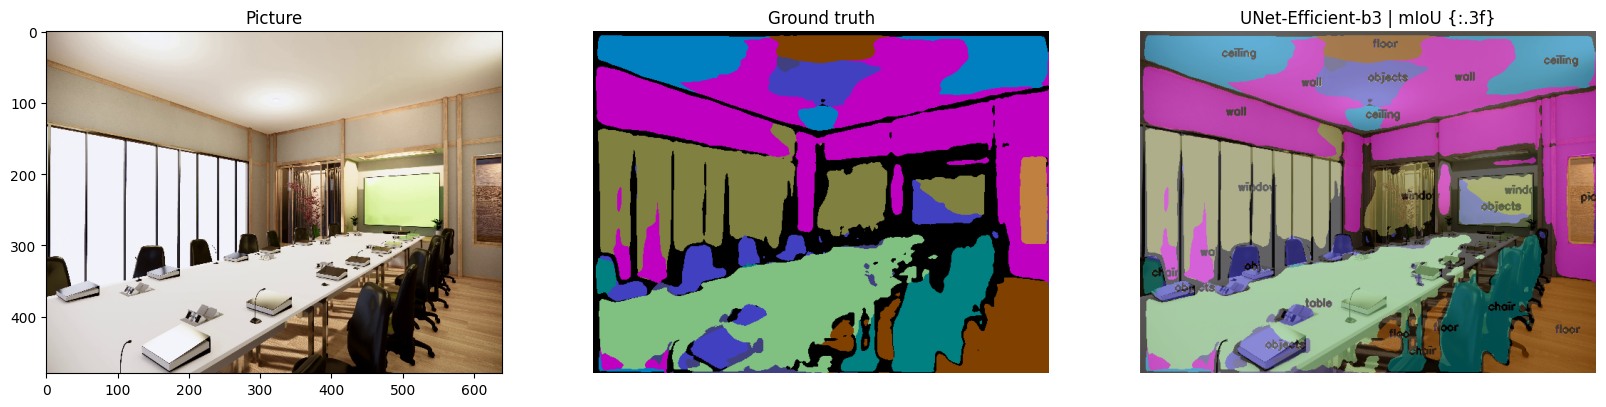

In [ ]:
# image2, mask2 = test_set[4]
# pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(frame)
ax1.set_title('Picture');

ax2.imshow(class_to_rgb(masked_frame, class_index))
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(frame_overlay)
ax3.set_title('UNet-Efficient-b3 | mIoU {:.3f}')
ax3.set_axis_off()

In [17]:
def process_image(link):
    image_org = cv2.imread(link)
    img = cv2.cvtColor(image_org, cv2.COLOR_BGR2RGB)
    # aug = transform(image=img)
    # img = (aug['image'])
    masked = predict_image(model, img)
    labeled_image = label_segmented_areas(np.ascontiguousarray(masked, dtype=np.uint8), class_labels)
    frame_overlay = overlay_image(img, labeled_image)
    return image_org, masked, frame_overlay



In [22]:
img1, mask1, overlay1 = process_image('/content/drive/MyDrive/NYU13/image/images/01383.png')
img2, mask2, overlay2 = process_image('/content/drive/MyDrive/NYU13/image/images/01383.png')
img3, mask3, overlay3 = process_image('/content/drive/MyDrive/NYU13/image/images/01383.png')
img4, mask4, overlay4 = process_image('/content/drive/MyDrive/NYU13/image/images/01383.png')
img5, mask5, overlay5 = process_image('/content/drive/MyDrive/NYU13/image/images/00007.png')


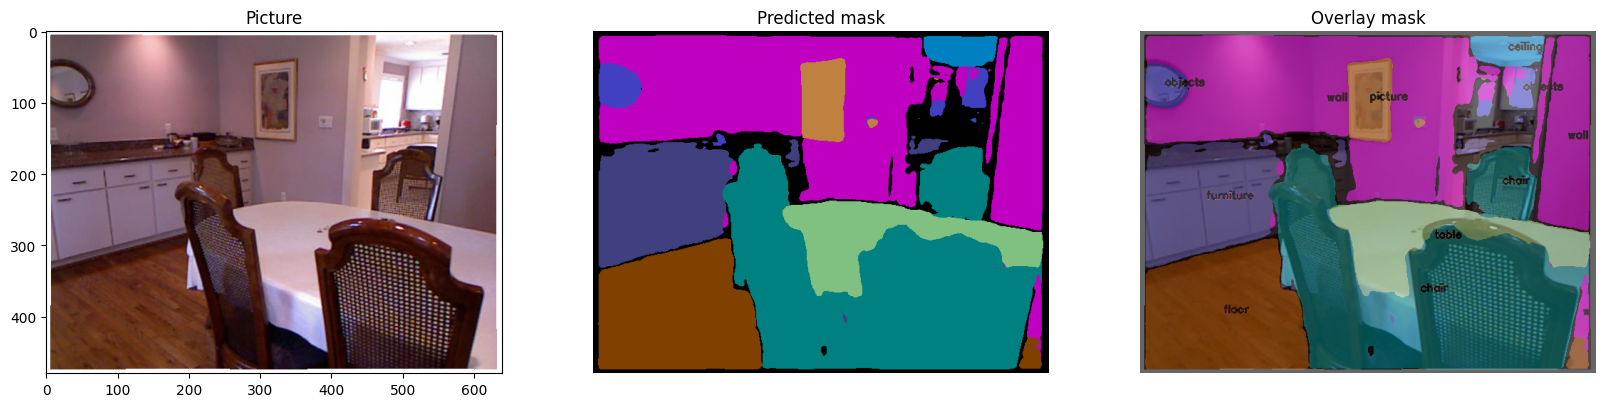

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_RGB2BGR))
ax1.set_title('Picture');

ax2.imshow(class_to_rgb(mask1, class_index))
ax2.set_title('Predicted mask')
ax2.set_axis_off()

ax3.imshow(overlay1)
ax3.set_title('Overlay mask')
ax3.set_axis_off()

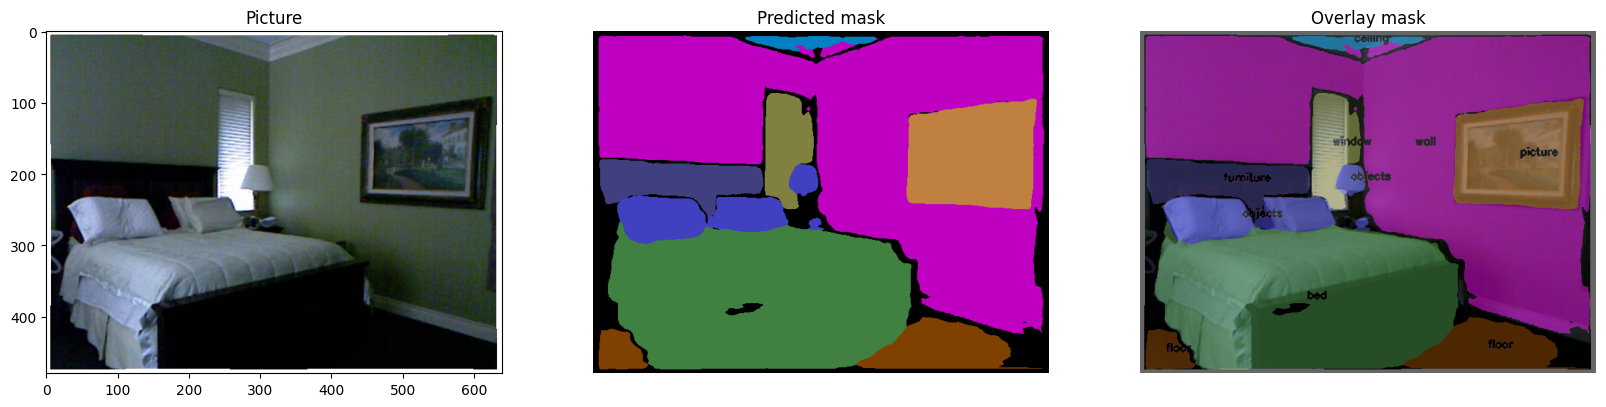

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
ax1.set_title('Picture');

ax2.imshow(class_to_rgb(mask2, class_index))
ax2.set_title('Predicted mask')
ax2.set_axis_off()

ax3.imshow(overlay2)
ax3.set_title('Overlay mask')
ax3.set_axis_off()

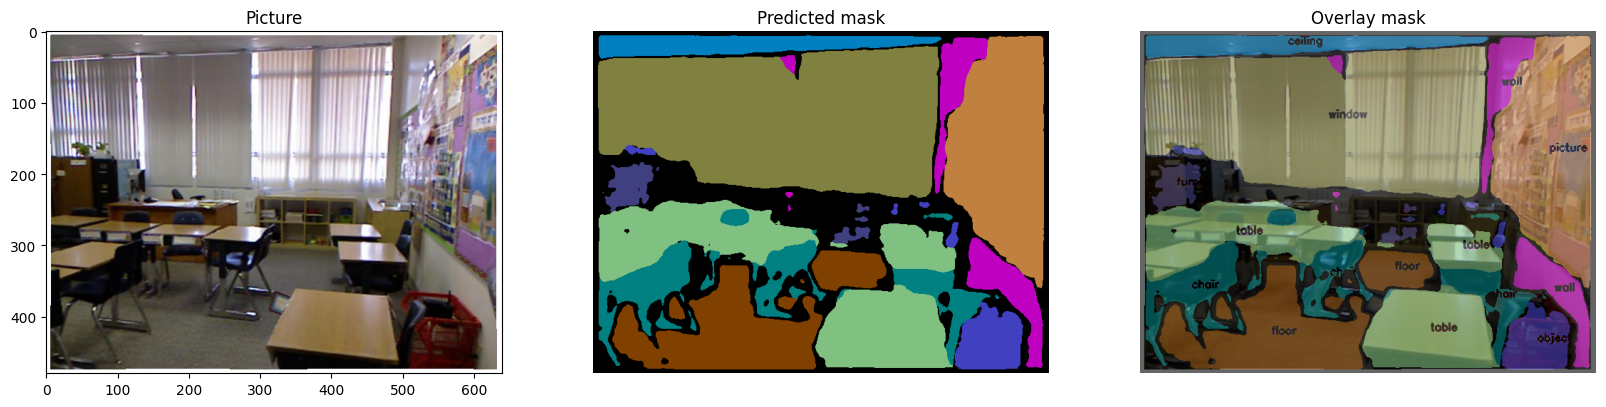

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img3, cv2.COLOR_RGB2BGR))
ax1.set_title('Picture');

ax2.imshow(class_to_rgb(mask3, class_index))
ax2.set_title('Predicted mask')
ax2.set_axis_off()

ax3.imshow(overlay3)
ax3.set_title('Overlay mask')
ax3.set_axis_off()

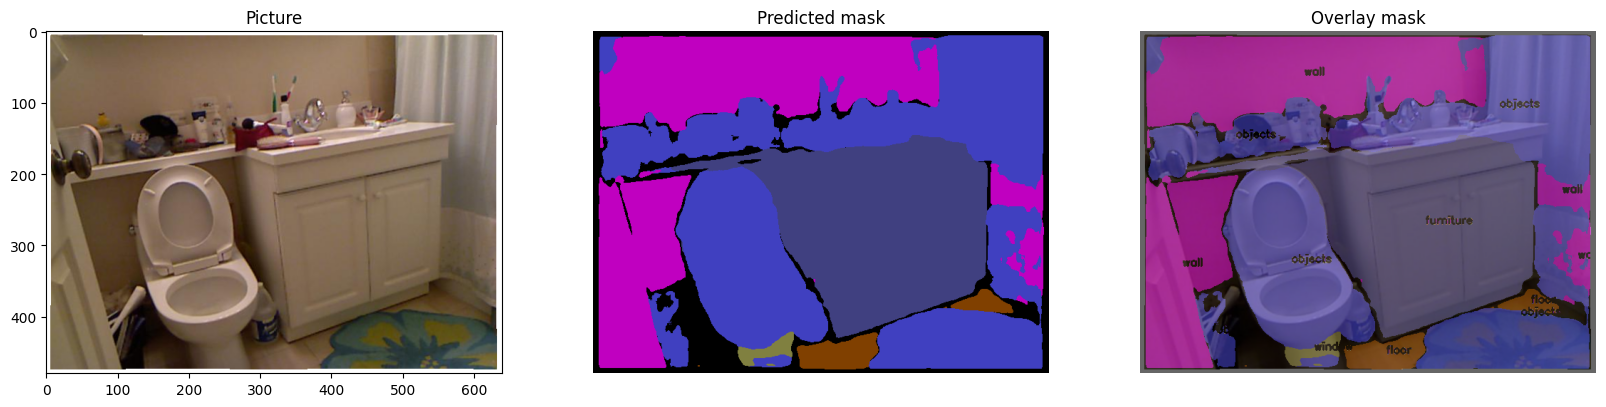

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img4, cv2.COLOR_RGB2BGR))
ax1.set_title('Picture');

ax2.imshow(class_to_rgb(mask4, class_index))
ax2.set_title('Predicted mask')
ax2.set_axis_off()

ax3.imshow(overlay4)
ax3.set_title('Overlay mask')
ax3.set_axis_off()

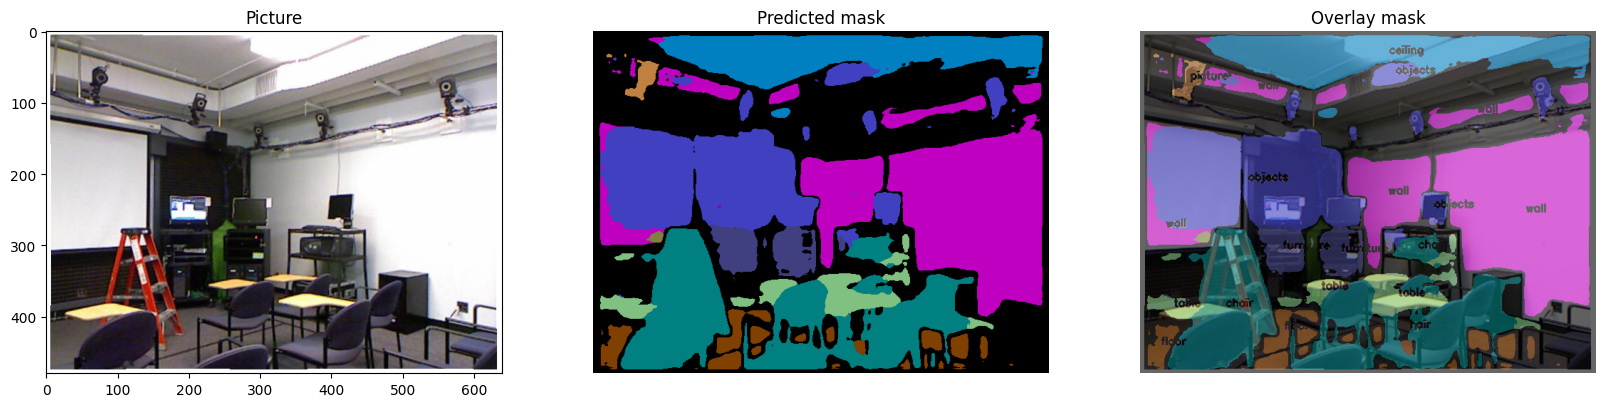

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img5, cv2.COLOR_RGB2BGR))
ax1.set_title('Picture');

ax2.imshow(class_to_rgb(mask5, class_index))
ax2.set_title('Predicted mask')
ax2.set_axis_off()

ax3.imshow(overlay5)
ax3.set_title('Overlay mask')
ax3.set_axis_off()